In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from make_network import *

DATA_DIR = "./data/"

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Functions

## Data

In [3]:
def prepare_data(seed):
    # 1 read data
    df = pd.read_csv(DATA_DIR + "/vols.csv")
    vcols = pd.read_csv(DATA_DIR + "/rois.csv")["roi"].values.tolist()

    # 2 preprocessing - normalize by intracranial volume
    for c in vcols:
        df[c] = df[c] / df["intra_vol"]

    # 3 split data
    idx_train, idx_test  = train_test_split(np.arange(df.shape[0]), test_size=0.4, random_state=seed)
    
    # 4 scale (standardize) data
    mean, std = df.iloc[idx_train][vcols].mean(), df.iloc[idx_train][vcols].std()
    df[vcols] = (df[vcols] - mean) / std
    
    return df, vcols, (idx_train, idx_test)    

## Plots

In [4]:
COLORS = ["#f9907a","#fff585","#d8ff85","#85ffc4","#85e5ff","#85bbff","#cf85ff","#f285ff","#fd98c9","#fd9898","#ffb357"]
def draw_graph_with_communities(G, ax=None, with_labels=True, layout = nx.spring_layout, seed=None, pos=None):
    from networkx.algorithms import community

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,10) )

    if pos == None:
        if seed is None:
            pos = layout(G)
        else:
            pos = layout(G, seed=seed)

    nx.draw(G, pos, ax=ax, with_labels=with_labels)

    communities = community.label_propagation_communities(G)
    for i, (comm, col) in enumerate( zip(communities, COLORS)):
        nx.draw_networkx_nodes(G, pos, nodelist=comm, node_color=col, ax=ax)

## Utils

In [5]:
def torch2nx(num_nodes, edge_index):
    """tensor of indices to nx.Graph"""
    G = nx.Graph()
    G.add_nodes_from(np.arange(num_nodes))
    G.add_edges_from(edge_index.T.numpy())
    return G

# Sparsity Hyperparameter

In this section we evaluate multiple graph theory-based metrics on the graphs obtained using different values for the sparsity hyperparameter so that we can select the optimal for further experiments such as brain age prediction. The evaluation is based on the density of the graph, node degree distribution, node centrality distribution, average short path length and clustering coefficient.


List of all $\alpha$ values to be employed. Both methods Graphical LASSO and Correlation-based (Regression Lasso) use the same range of values.

In [6]:
# alpha values
alphas  = [1, 7.5e-1, 5e-1, 2.5e-1, 1e-1, 7.5e-2, 5e-2, 2.5e-2, 1e-2, 7.5e-3, 5e-3, 2.5e-3, 1e-3, 7.5e-4, 5e-4, 2.5e-4, 1e-4]
alphas_idx = ["{:.2e}".format(a) for a in alphas]

In [7]:
df,vcols,(idx_train,_) = prepare_data(0)

num_nodes = len(vcols)
x  = df.iloc[idx_train][vcols].values

Pre-compute all the graphs needed, this may take a while...

In [8]:
gl_Gs, rl_Gs = list(), list()
for i, alpha in enumerate(alphas):
    # graphical lasso
    edge_index, _ = make_graphical_lasso(x, alpha)
    G = torch2nx(num_nodes, edge_index)
    gl_Gs.append(G)
    
    # regression lasso
    edge_index, _ = make_regression_lasso(x, alpha)
    G = torch2nx(num_nodes, edge_index)
    rl_Gs.append(G)        

## Density

Density of the graphs generated as function of $\lambda$. 
The lower $\lambda$, the more dense the graph. However, correlation-based graph converges to a density of 0.18 as we decrease $\lambda$ whereas graphical LASSO ends up inferring the complete graph.

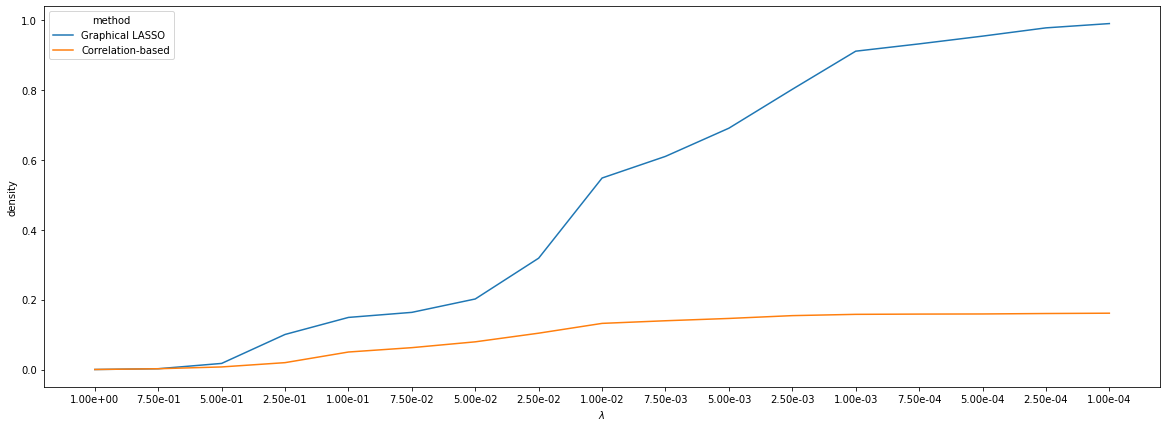

In [9]:
# density
gl_densities = pd.DataFrame({'density':[nx.density(G) for G in gl_Gs], '$ \lambda $':alphas_idx})
rl_densities = pd.DataFrame({'density':[nx.density(G) for G in rl_Gs], '$ \lambda $':alphas_idx})

plt.figure(figsize=(20,7))
gl_densities['method'] = "Graphical LASSO"
rl_densities['method'] = "Correlation-based"
df_densities = pd.concat([gl_densities, rl_densities], axis=0).reset_index()
sns.lineplot(data=df_densities, x = '$ \lambda $', y = 'density', hue='method')
plt.show()
#plt.savefig("density.png", bbox_inches='tight')

## Node Degree

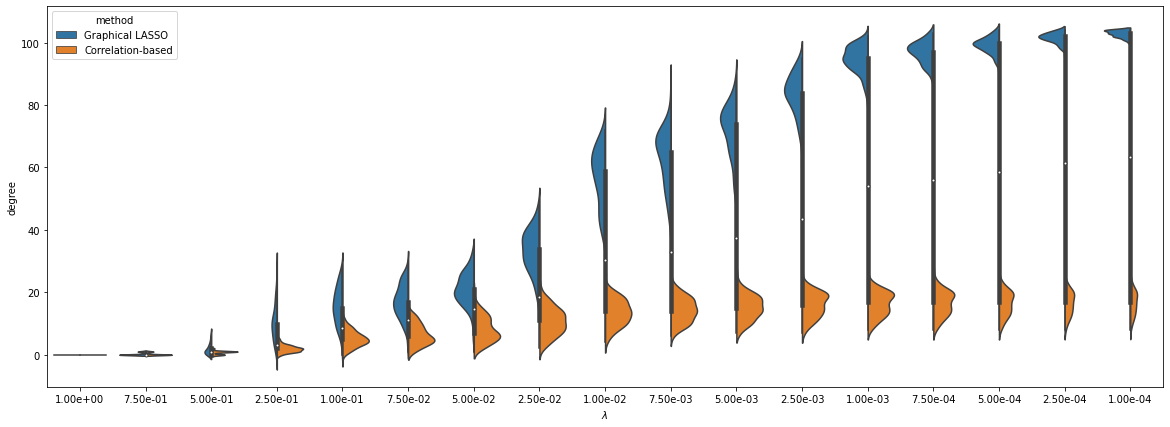

In [10]:
# degree
gl_degree = pd.DataFrame({'degree':[np.array(nx.degree(G))[:,1] for G in gl_Gs], '$ \lambda $':alphas_idx})
lr_degree = pd.DataFrame({'degree':[np.array(nx.degree(G))[:,1] for G in rl_Gs], '$ \lambda $':alphas_idx})

gl_deg = pd.DataFrame(np.stack([np.array(nx.degree(G))[:,1] for G in gl_Gs], axis=0).T, columns=alphas_idx)\
            .melt(var_name='$ \lambda $', value_name='degree')
gl_deg['method'] = "Graphical LASSO"

rl_deg = pd.DataFrame(np.stack([np.array(nx.degree(G))[:,1] for G in rl_Gs], axis=0).T, columns=alphas_idx)\
            .melt(var_name='$ \lambda $', value_name='degree')
rl_deg['method'] = "Correlation-based"


plt.figure(figsize=(20,7))
gl_deg['method'] = "Graphical LASSO"
rl_deg['method'] = "Correlation-based"
df_deg = pd.concat([gl_deg, rl_deg], axis=0).reset_index()
sns.violinplot(data=df_deg, x='$ \lambda $', y='degree', hue='method', split=True)
plt.show()
#plt.savefig("degree.png", bbox_inches='tight')

## Node Average Short Path Length

Function to compute the average short path length distribution. If two nodes are not reachable, the path length betweem them is set to be equal to the number of nodes of the graph.

In [11]:
def node_avg_short_path_len_distribution(graph):
    spl = [ d for d in nx.shortest_path_length(graph) ]
    df = pd.DataFrame([s[1] for s in spl])

    num_nodes = df.shape[0]
    df = df[ np.arange(0, num_nodes) ].fillna(num_nodes)
    node_short_path_len = (df.sum() / (num_nodes - 1)).values

    return node_short_path_len

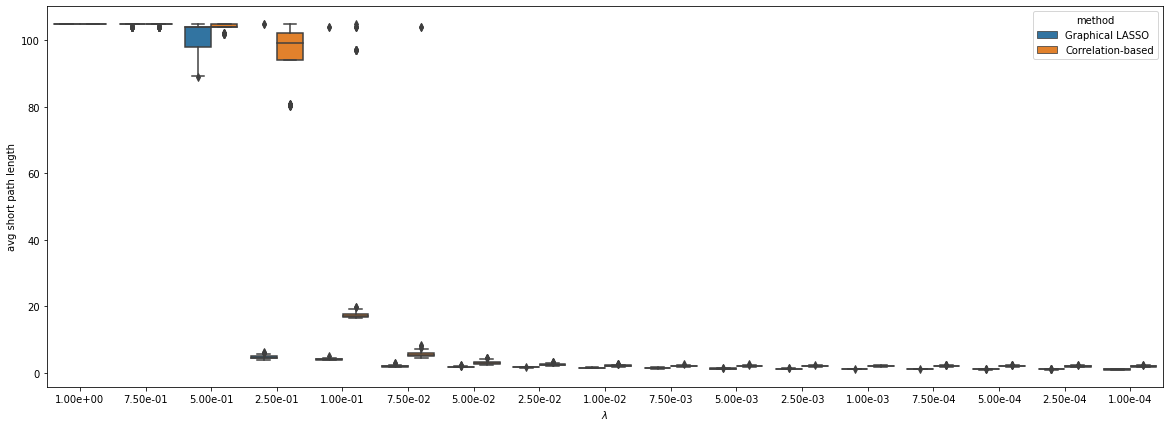

In [12]:
gl_spl = pd.DataFrame(np.stack([node_avg_short_path_len_distribution(G) for G in gl_Gs],axis=0).T, columns=alphas_idx).melt(var_name='$ \lambda $', value_name='avg short path length')
gl_spl['method'] = "Graphical LASSO"
rl_spl = pd.DataFrame(np.stack([node_avg_short_path_len_distribution(G) for G in rl_Gs],axis=0).T, columns=alphas_idx).melt(var_name='$ \lambda $', value_name='avg short path length')
rl_spl["method"] = "Correlation-based"

df_spl = pd.concat([gl_spl, rl_spl], axis=0)

plt.figure(figsize=(20,7))
sns.boxplot(data=df_spl, x='$ \lambda $', y='avg short path length', hue='method')
plt.show()
#plt.savefig("aspl_boxplot.png", bbox_inches='tight')

## Clustering Coefficient

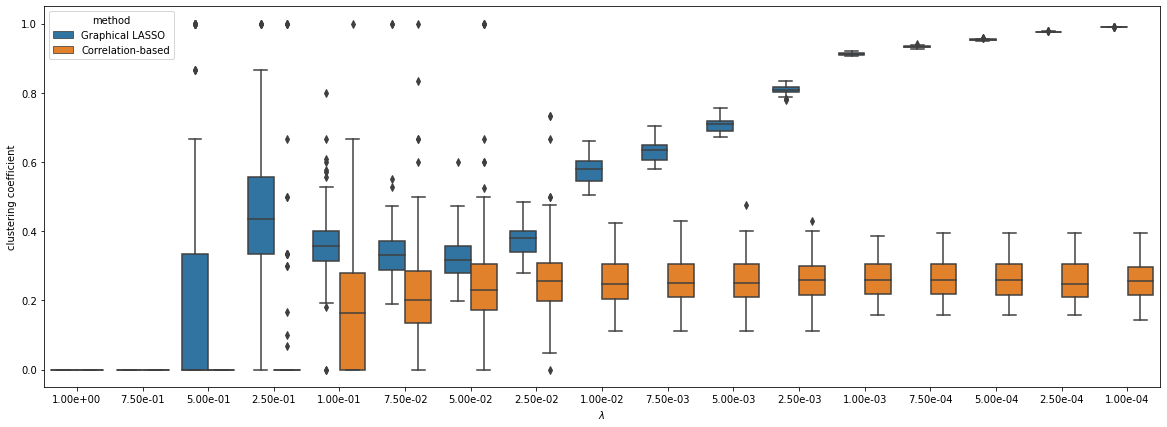

In [13]:
gl_clust = pd.DataFrame(np.stack([np.array(list(nx.clustering(G).values())) for G in gl_Gs], axis=0).T, columns=alphas_idx).melt(var_name='$ \lambda $', value_name='clustering coefficient')
gl_clust['method'] = "Graphical LASSO"

rl_clust = pd.DataFrame(np.stack([np.array(list(nx.clustering(G).values())) for G in rl_Gs], axis=0).T, columns=alphas_idx).melt(var_name='$ \lambda $', value_name='clustering coefficient')
rl_clust['method'] = "Correlation-based"

df_clust = pd.concat([gl_clust, rl_clust], axis=0)

plt.figure(figsize=(20,7))
sns.boxplot(data=df_clust, x='$ \lambda $', y='clustering coefficient', hue='method')
plt.show()
#plt.savefig("clust_boxplot.png", bbox_inches='tight')

## Node Centrality

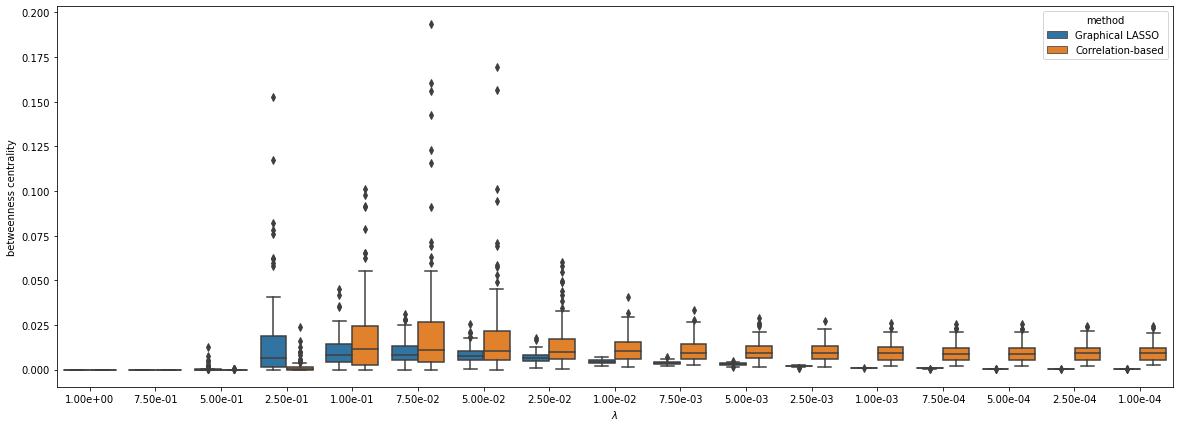

In [14]:
gl_cent = pd.DataFrame(np.stack([np.array(list(nx.betweenness_centrality(G).values())) for G in gl_Gs], axis=0).T, columns=alphas_idx).melt(var_name='$ \lambda $', value_name='betweenness centrality')
gl_cent['method'] = "Graphical LASSO"

rl_cent = pd.DataFrame(np.stack([np.array(list(nx.betweenness_centrality(G).values())) for G in rl_Gs], axis=0).T, columns=alphas_idx).melt(var_name='$ \lambda $', value_name='betweenness centrality')
rl_cent['method'] = "Correlation-based"

df_cent = pd.concat([gl_cent, rl_cent], axis=0)

plt.figure(figsize=(20, 7))
sns.boxplot(data=df_cent, x='$ \lambda $', y='betweenness centrality', hue='method')
plt.show()
#plt.savefig("cent_boxplot.png", bbox_inches='tight')

## Final Plots

In [15]:
alpha_rl, alpha_gl = 5e-2, 3e-1

In [16]:
ei_rl,_ = make_regression_lasso(x, alpha_rl)
ei_gl,_ = make_graphical_lasso(x,  alpha_gl)
G_rl    = torch2nx(num_nodes, ei_rl)
G_gl    = torch2nx(num_nodes, ei_gl)

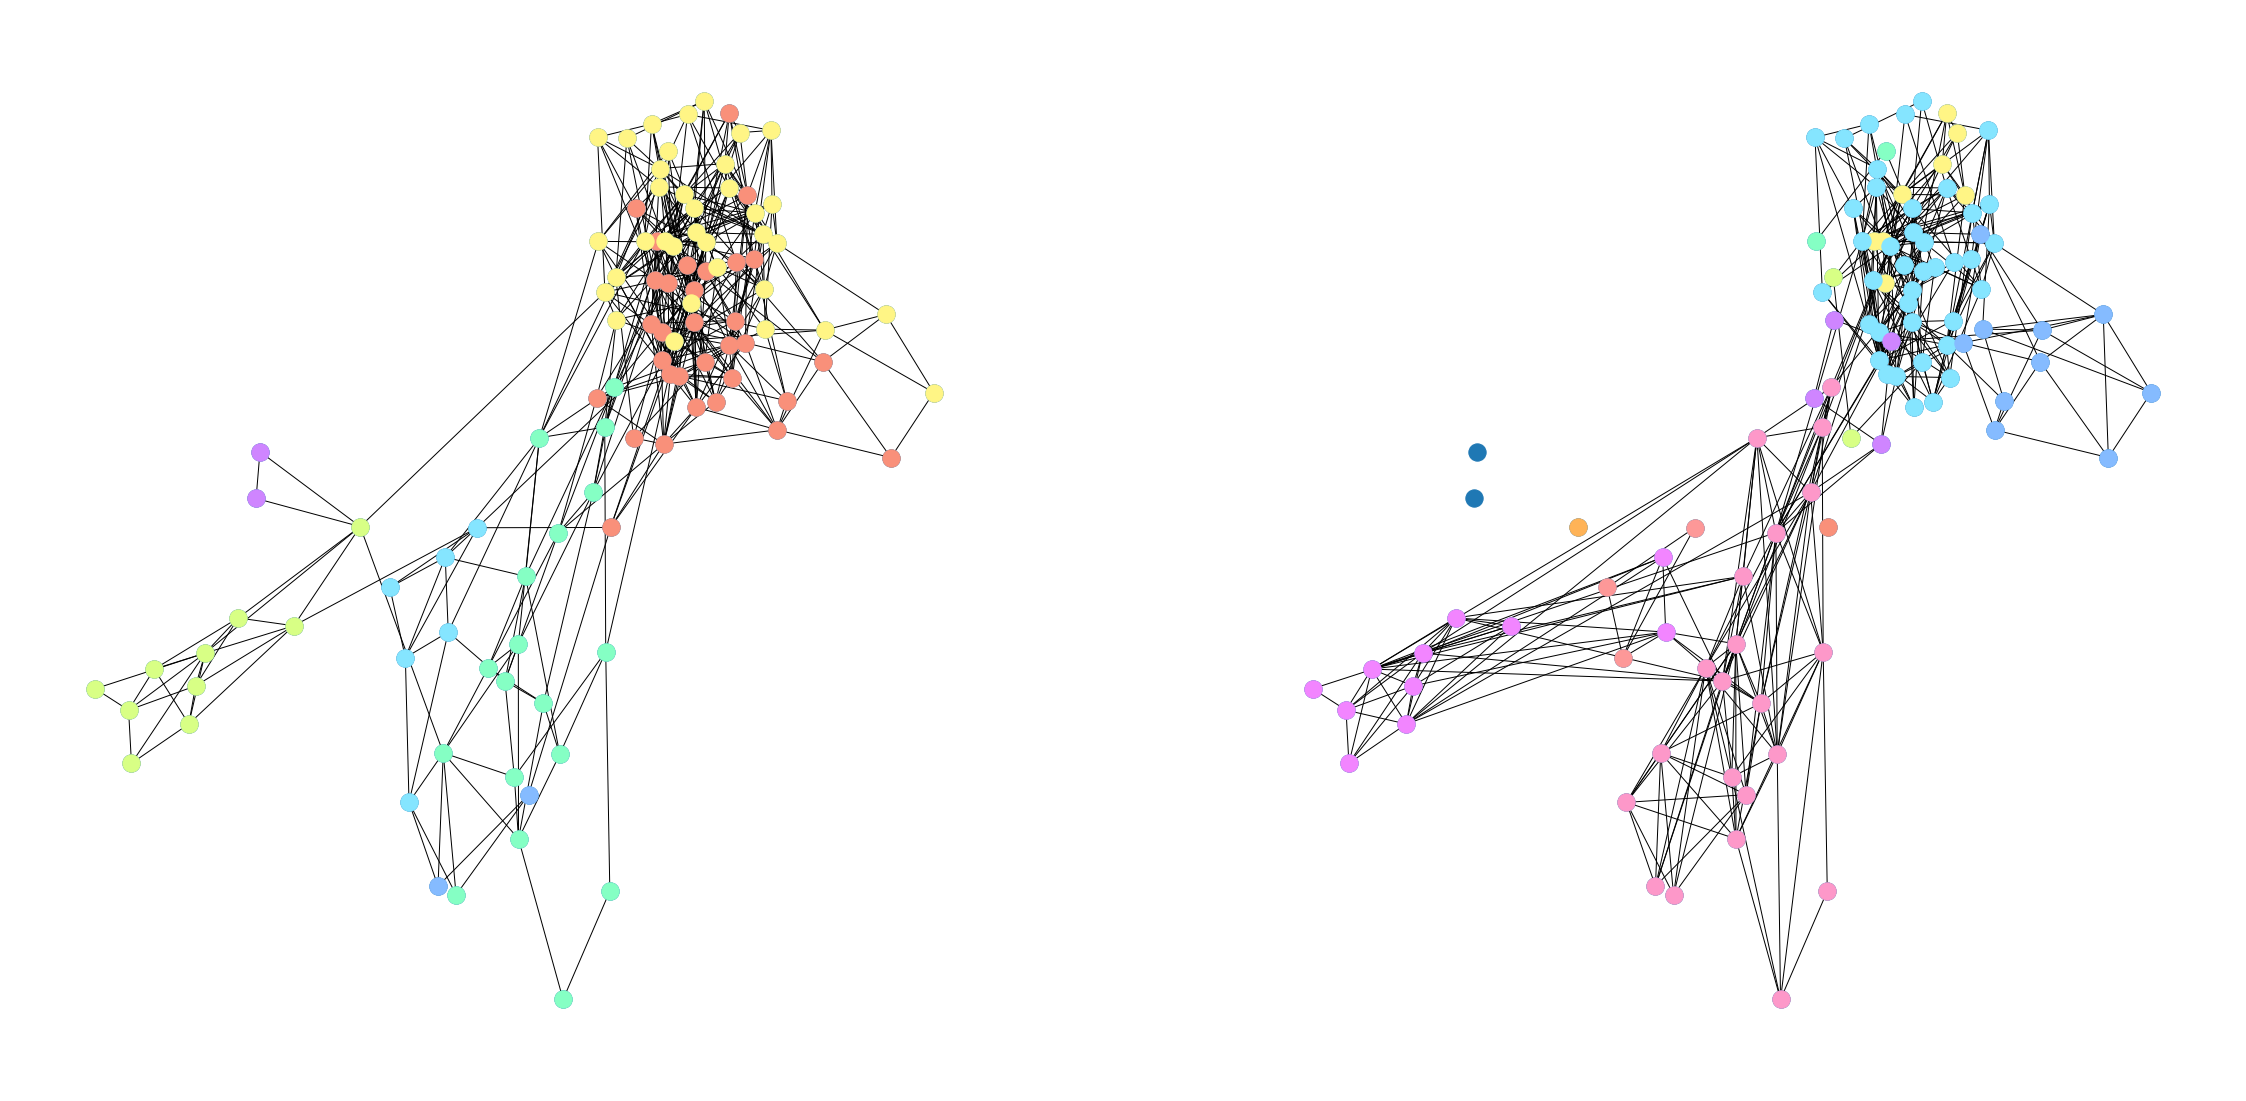

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(40, 20))

pos_spring = nx.spring_layout(G_rl, seed=38)

nx.draw(G_rl, pos_spring, ax=ax[0])
nx.draw(G_gl, pos_spring, ax=ax[1])

comm_rl = nx.community.label_propagation_communities(G_rl)
comm_gl = nx.community.label_propagation_communities(G_gl)

for i, (comm, col) in enumerate( zip(comm_rl, COLORS)):
    nx.draw_networkx_nodes(G_rl, pos_spring, nodelist=comm, node_color=col, ax=ax[0])

for i, (comm, col) in enumerate( zip(comm_gl, COLORS)):
    nx.draw_networkx_nodes(G_gl, pos_spring, nodelist=comm, node_color=col, ax=ax[1])

# APOE Structural Connectivity Differences

Quantify network differences between the graphs obtained by only including apoe-carriers vs apoe-non-carriers. The main differences can be seen in the volume (sum of links) of the right subcortex, that is higher for apoe carriers.

In [25]:
alpha_rl = 5e-2

Set APOE carriers as the ones with the allele 4.

In [26]:
df,vcols,(idx_train,_) = prepare_data(0)
num_nodes = len(vcols)
x  = df.iloc[idx_train][vcols].values

df["apoe_carriers"] = df["apoe"].apply(lambda x : 1 if int(x) in [24, 34, 44] else 0)
apoes = [0, 1]
df.iloc[idx_train].groupby("apoe_carriers").count()

,sex,age,apoe,intra_vol,left_bankssts,right_bankssts,left_caudalanteriorcingulate,right_caudalanteriorcingulate,left_caudalmiddlefrontal,right_caudalmiddlefrontal,...,left_putamen,right_putamen,left_thalamusproper,right_thalamusproper,left_ventraldc,right_ventraldc,left_choroidplexus,right_choroidplexus,left_vessel,right_vessel
apoe_carriers,,,,,,,,,,,,,,,,,,,,,
0,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,...,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724
1,4199,4199,4199,4199,4199,4199,4199,4199,4199,4199,...,4199,4199,4199,4199,4199,4199,4199,4199,4199,4199


Compute graphs using all subjects (G), only apoe non-carriers (G_apoe0) and only apoe carriers (G_apoe1) for 1000 different data splits. This may take a while as well, you can reduce the number of runs.

In [27]:
Gs, Gs_apoe0, Gs_apoe1 = list(), list(), list()
for s in range(1000):
    print(s)
    # read, preprocess and split data
    df, vcols, (idx_train, _) = prepare_data(s)
    num_nodes = len(vcols)
    # set apoe carriers label
    df_train = df.iloc[idx_train]
    df_train["apoe_carriers"] = df_train["apoe"].apply(lambda x : 1 if x in [24, 34, 44] else 0)

    # split into apoe carriers (_apoe1) and non-carriers (_apoe0)
    x_apoe0 = df_train[ df_train.apoe_carriers == 0 ][vcols].values
    x_apoe1 = df_train[ df_train.apoe_carriers == 1 ][vcols].values
    
    # random permutation and subindex to ensure same num of subjects
    idx = np.random.permutation(x_apoe0.shape[0])[:x_apoe1.shape[0]]
    x_apoe0 = x_apoe0[idx,:]
    
    # make network employing regression lasso (correlation-based) strategy
    ei_apoe0,_ = make_regression_lasso(x_apoe0, alpha_rl)
    ei_apoe1,_ = make_regression_lasso(x_apoe1, alpha_rl)
    
    # edge index to networkx graph
    G_apoe0 = torch2nx(num_nodes, ei_apoe0)
    G_apoe1 = torch2nx(num_nodes, ei_apoe1)
    
    # append to list of graphs
    Gs_apoe0.append(G_apoe0)
    Gs_apoe1.append(G_apoe1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [28]:
# function to get volume of subcortex, cortex, right-cortex and left-cortex
def volume(G):
    ctx = nx.volume(G, np.arange(0,66))
    sctx = nx.volume(G, np.arange(66,num_nodes))

    ctx_rgt = nx.volume(G, [i for i in range(66) if i%2==1])
    ctx_lft  = nx.volume(G, [i for i in range(66) if i%2==0])

    return sctx, ctx, ctx_rgt, ctx_lft

In [29]:
# subcortex, cortex, right-cortex, left-cortex of all apoe non-carriers networks
vhist_apoe0 = pd.DataFrame([volume(G) for G in Gs_apoe0], columns=["sctx","ctx","ctx_rgt","ctx_lft"])
vhist_apoe0["apoe"] = "non-carrier"
# subcortex, cortex, right-cortex, left-cortex of all apoe carriers networks
vhist_apoe1 = pd.DataFrame([volume(G) for G in Gs_apoe1], columns=["sctx","ctx","ctx_rgt","ctx_lft"])
vhist_apoe1["apoe"] = "carrier"
# combination
vhist = pd.concat([vhist_apoe0, vhist_apoe1], axis=0).reset_index()

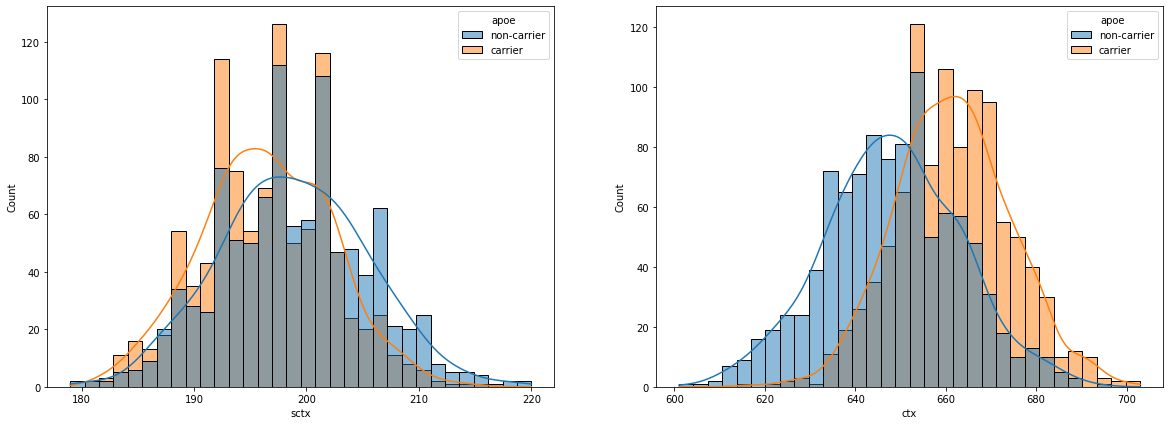

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
sns.histplot(data=vhist, x='sctx', hue='apoe', ax=ax[0], bins=32, kde=True)
sns.histplot(data=vhist, x='ctx',  hue='apoe', ax=ax[1], bins=32, kde=True)
plt.show()

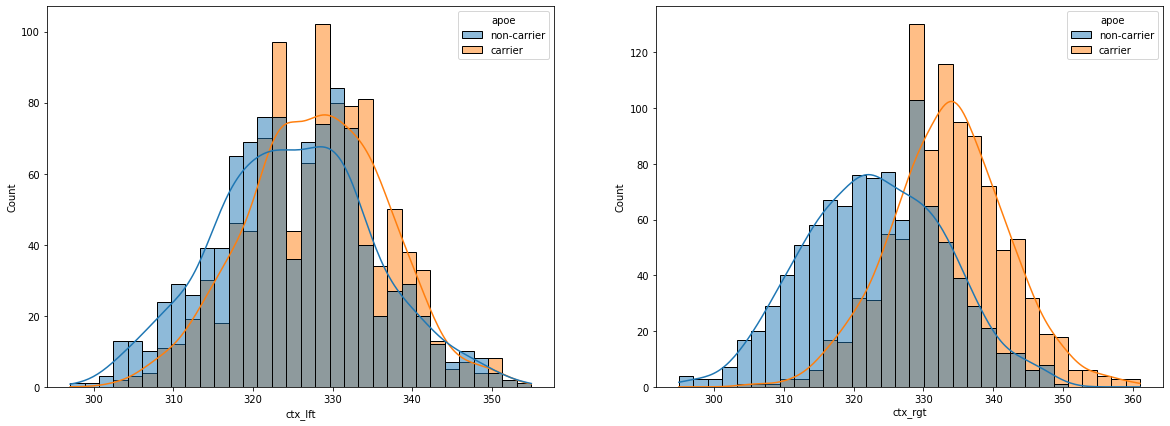

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
sns.histplot(data=vhist, x='ctx_lft', hue='apoe', ax=ax[0], bins=32, kde=True)
sns.histplot(data=vhist, x='ctx_rgt', hue='apoe', ax=ax[1], bins=32, kde=True)
plt.show()